# Inference plots - Trace plots

This example builds on the [adaptive covariance MCMC example](https://github.com/pints-team/pints/blob/master/examples/sampling-adaptive-covariance-mcmc.ipynb), and shows you a different way to plot the results.

Inference plots:
* [Predicted time series](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-predicted-time-series.ipynb)
* __Trace plots__
* [Autocorrelation](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-autocorrelation.ipynb)
* [Pairwise scatterplots](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-pairwise-scatterplots.ipynb)
* [Pairwise scatterplots with KDE](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-pairwise-kde-plots.ipynb)


## Setting up an MCMC routine

See the adaptive covariance MCMC example for details.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 50
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Perform sampling using MCMC, with three chains
xs = [
    real_parameters * 1.1,
    real_parameters * 1.15,
    real_parameters * 0.9,
]
mcmc = pints.MCMCSampling(log_posterior, 3, xs)
mcmc.set_max_iterations(6000)
mcmc.set_log_to_screen(False)

## Traces

The plots below show the chains generated by three independent runs of the adaptive MCMC routine (all from the same starting point). All three chains require an initial period (usually discarded as 'burn-in') before they converge to the same parameter values. These initial samples distort the shape of the histograms seen on the right.

In [2]:
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Done!


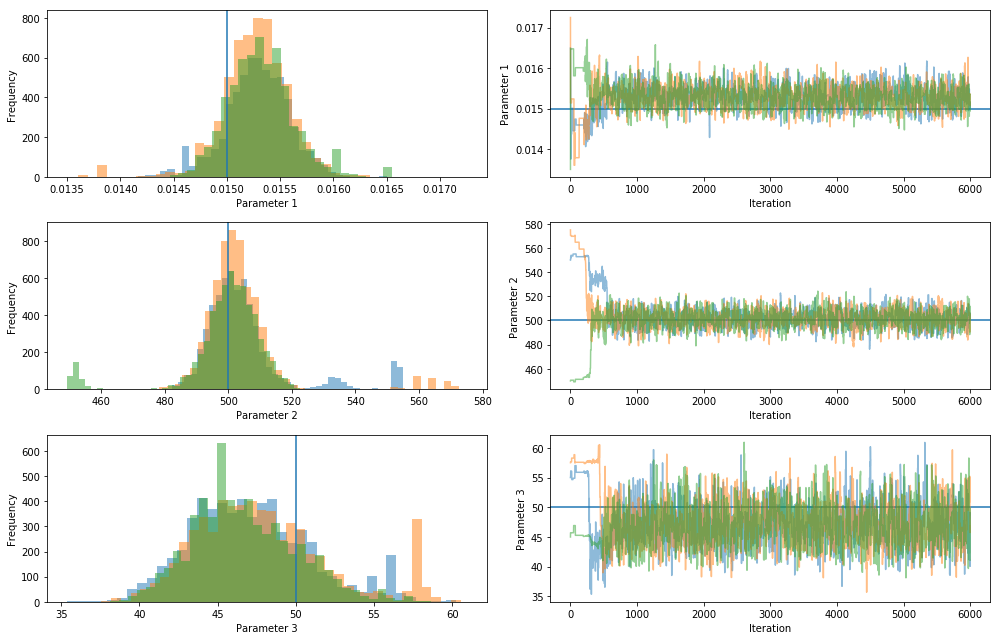

In [3]:
# Show histogram and traces
plt.figure(figsize=(14, 9))
nparam = len(real_parameters)
for i, real in enumerate(real_parameters):

    # Add trace subplot
    plt.subplot(nparam, 2, 2 + 2 * i)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter ' + str(i + 1))
    plt.axhline(real)
    plt.plot(chains[0,:,i], alpha=0.5)
    plt.plot(chains[1,:,i], alpha=0.5)
    plt.plot(chains[2,:,i], alpha=0.5)
    
    # Add histogram subplot
    plt.subplot(nparam, 2, 1 + 2 * i)
    plt.xlabel('Parameter ' + str(i + 1))
    plt.ylabel('Frequency')
    plt.axvline(real)
    plt.hist(chains[0,:,i], label='p' + str(i + 1), bins=40, alpha=0.5)
    plt.hist(chains[1,:,i], label='p' + str(i + 1), bins=40, alpha=0.5)
    plt.hist(chains[2,:,i], label='p' + str(i + 1), bins=40, alpha=0.5)

plt.tight_layout()
plt.show()